# Classifying Names with a Character-Level RNN
We will be building and training a basic character-level RNN to classify words. A character-level RNN reads words as a series of characters - outputting a prediction and "hidden state" at each step, feeding its previous hidden state into each next step. We take the final prediction to be the output, i.e. which class the word belongs to.

Specifically, we'll train on a few thousand surnames from 18 languages of origin, and predict which language a name is from based on the spelling

In [31]:
import glob

all_filenames = glob.glob('/content/drive/MyDrive/Colab Notebooks/NLP/CLASSIFYING NAMES WITH A CHARACTER-LEVEL RNN/data/names/*.txt')
print(' type of file : ',type(all_filenames),'\n',
      'Number of file : ', len(all_filenames),'\n',
      'List of all file : \n ',all_filenames)

 type of file :  <class 'list'> 
 Number of file :  18 
 List of all file : 
  ['/content/drive/MyDrive/Colab Notebooks/NLP/CLASSIFYING NAMES WITH A CHARACTER-LEVEL RNN/data/names/Japanese.txt', '/content/drive/MyDrive/Colab Notebooks/NLP/CLASSIFYING NAMES WITH A CHARACTER-LEVEL RNN/data/names/Arabic.txt', '/content/drive/MyDrive/Colab Notebooks/NLP/CLASSIFYING NAMES WITH A CHARACTER-LEVEL RNN/data/names/Portuguese.txt', '/content/drive/MyDrive/Colab Notebooks/NLP/CLASSIFYING NAMES WITH A CHARACTER-LEVEL RNN/data/names/Vietnamese.txt', '/content/drive/MyDrive/Colab Notebooks/NLP/CLASSIFYING NAMES WITH A CHARACTER-LEVEL RNN/data/names/Polish.txt', '/content/drive/MyDrive/Colab Notebooks/NLP/CLASSIFYING NAMES WITH A CHARACTER-LEVEL RNN/data/names/Scottish.txt', '/content/drive/MyDrive/Colab Notebooks/NLP/CLASSIFYING NAMES WITH A CHARACTER-LEVEL RNN/data/names/English.txt', '/content/drive/MyDrive/Colab Notebooks/NLP/CLASSIFYING NAMES WITH A CHARACTER-LEVEL RNN/data/names/Italian.txt', '/

In [32]:
import unicodedata # This module provides access to the Unicode Character Database (UCD) which defines character properties for all Unicode characters. The data contained in this database is compiled from the UCD version 14.0.0.
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
print('Before all_letters - {} and len of n_letters - {}'.format(all_letters,n_letters))

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s) #Return the normal form form for the Unicode string unistr. Valid values for form are ‘NFC’, ‘NFKC’, ‘NFD’, and ‘NFKD’.
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print('Remove special charecter : ',unicode_to_ascii('Ślusàrski'))
print('After all_letters - {} and len of n_letters - {}'.format(all_letters,n_letters))

Before all_letters - abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;' and len of n_letters - 57
Remove special charecter :  Slusarski
After all_letters - abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;' and len of n_letters - 57


In [33]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename).read().strip().split('\n')
    print('line', lines)
    return [unicode_to_ascii(line) for line in lines]

for filename in all_filenames:
    category = filename.split('/')[-1].split('.')[0]
    print('category', category)
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
print('n_categories =', n_categories)

category Japanese
line ['Abe', 'Abukara', 'Adachi', 'Aida', 'Aihara', 'Aizawa', 'Ajibana', 'Akaike', 'Akamatsu', 'Akatsuka', 'Akechi', 'Akera', 'Akimoto', 'Akita', 'Akiyama', 'Akutagawa', 'Amagawa', 'Amaya', 'Amori', 'Anami', 'Ando', 'Anzai', 'Aoki', 'Arai', 'Arakawa', 'Araki', 'Arakida', 'Arato', 'Arihyoshi', 'Arishima', 'Arita', 'Ariwa', 'Ariwara', 'Asahara', 'Asahi', 'Asai', 'Asano', 'Asanuma', 'Asari', 'Ashia', 'Ashida', 'Ashikaga', 'Asuhara', 'Atshushi', 'Ayabito', 'Ayugai', 'Baba', 'Baisotei', 'Bando', 'Bunya', 'Chiba', 'Chikamatsu', 'Chikanatsu', 'Chino', 'Chishu', 'Choshi', 'Daishi', 'Dan', 'Date', 'Dazai', 'Deguchi', 'Deushi', 'Doi', 'Ebina', 'Ebisawa', 'Eda', 'Egami', 'Eguchi', 'Ekiguchi', 'Endo', 'Endoso', 'Enoki', 'Enomoto', 'Erizawa', 'Eto', 'Etsuko', 'Ezakiya', 'Fuchida', 'Fugunaga', 'Fujikage', 'Fujimaki', 'Fujimoto', 'Fujioka', 'Fujishima', 'Fujita', 'Fujiwara', 'Fukao', 'Fukayama', 'Fukuda', 'Fukumitsu', 'Fukunaka', 'Fukuoka', 'Fukusaku', 'Fukushima', 'Fukuyama', 'Fuku

In [34]:
print(category_lines['Vietnamese'][:5])

['Nguyen', 'Tron', 'Le', 'Pham', 'Huynh']


# Turning Names into Tensors
Now that we have all the names organized, we need to turn them into Tensors to make any use of them.

To represent a single letter, we use a "one-hot vector" of size <1 x n_letters>. A one-hot vector is filled with 0s except for a 1 at index of the current letter, e.g. "b" = <0 1 0 0 0 ...>.

To make a word we join a bunch of those into a 2D matrix <line_length x 1 x n_letters>.

That extra 1 dimension is because PyTorch assumes everything is in batches - we're just using a batch size of 1 here.

In [35]:
torch.zeros(1, 10)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [36]:
import torch

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letter_to_tensor(letter):
    tensor = torch.zeros(1, n_letters)
    # print('zero tensor : ', tensor)
    letter_index = all_letters.find(letter)
    # print('letter_index', letter_index)
    tensor[0][letter_index] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    # print('tensor', tensor,'line',line)
    for li, letter in enumerate(line):
        letter_index = all_letters.find(letter)
        tensor[li][0][letter_index] = 1
    return tensor

In [37]:
print(letter_to_tensor('J'))

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])


In [38]:
print(line_to_tensor('Jones').size())

torch.Size([5, 1, 57])


In [58]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [40]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)    ## input_size = 57, hidden_size=128, output_size = 18

In [41]:
input = Variable(letter_to_tensor('A'))
hidden = rnn.init_hidden()

output, next_hidden = rnn(input, hidden)
print('output.size =', output.size())

output.size = torch.Size([1, 18])


<ipython-input-39-1b65a3479df0>:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.softmax(output)


In [42]:
input = Variable(line_to_tensor('Albert'))
hidden = Variable(torch.zeros(1, n_hidden))

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8519, -2.8045, -2.8635, -2.9985, -2.8809, -3.0078, -2.9168, -2.9273,
         -2.8785, -2.8930, -2.8380, -2.9317, -2.8715, -2.8202, -2.8265, -2.9655,
         -2.8059, -2.9803]], grad_fn=<LogSoftmaxBackward0>)


<ipython-input-39-1b65a3479df0>:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.softmax(output)


# Training
### Preparing for Training
Before going into training we should make a few helper functions. The first is to interpret the output of the network, which we know to be a likelihood of each category. We can use Tensor.topk to get the index of the greatest value

In [60]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Greek', 12)


In [53]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = line_to_tensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Korean / line = Ku
category = Greek / line = Demarchis
category = German / line = Neumann
category = Russian / line = Zhitarev
category = Irish / line = Aodha
category = Spanish / line = Varela
category = Vietnamese / line = Sai
category = German / line = Rothschild
category = Italian / line = Uberti
category = Russian / line = Yanzhul


In [54]:
criterion = nn.NLLLoss()

# Training the Network
Now all it takes to train this network is show it a bunch of examples, have it make guesses, and tell it if it's wrong.

For the loss function nn.NLLLoss is appropriate, since the last layer of the RNN is nn.LogSoftmax.

In [45]:
criterion = nn.NLLLoss()

In [55]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [61]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 5s) 2.0176 Yoshimatsu / Japanese ✓
10000 10% (0m 12s) 0.1539 Totolos / Greek ✓
15000 15% (0m 18s) 1.1367 Coelho / Italian ✗ (Portuguese)
20000 20% (0m 24s) 2.5105 Chandler / German ✗ (English)
25000 25% (0m 31s) 1.5995 Van / Chinese ✗ (Vietnamese)
30000 30% (0m 37s) 2.4080 Simons / Dutch ✗ (German)
35000 35% (0m 44s) 1.1522 Prchal / Czech ✓
40000 40% (0m 50s) 2.3877 Jewson / Scottish ✗ (English)
45000 45% (0m 57s) 3.0118 Seymour / German ✗ (English)
50000 50% (1m 3s) 1.3027 Costa / Spanish ✓
55000 55% (1m 10s) 1.0694 Archambault / French ✓
60000 60% (1m 15s) 1.0505 Alves / Portuguese ✓
65000 65% (1m 22s) 1.0421 Guerra / Spanish ✗ (Portuguese)
70000 70% (1m 28s) 2.6242 Haanrade / Irish ✗ (Dutch)
75000 75% (1m 36s) 0.4936 Song / Korean ✓
80000 80% (1m 43s) 1.3515 Vilaro / Italian ✗ (Spanish)
85000 85% (1m 49s) 3.0442 Nifterik / Czech ✗ (Dutch)
90000 90% (1m 56s) 0.0929 Karahalios / Greek ✓
95000 95% (2m 2s) 0.1051 Sklavenitis / Greek ✓
100000 100% (2m 9s) 1.0304 Williamson / 

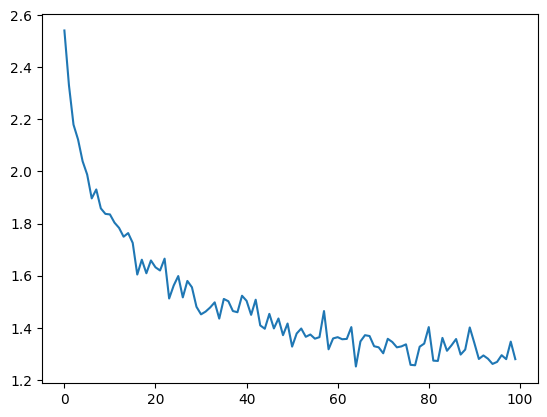

In [62]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

<ipython-input-63-a5b341ffc3a3>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-63-a5b341ffc3a3>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


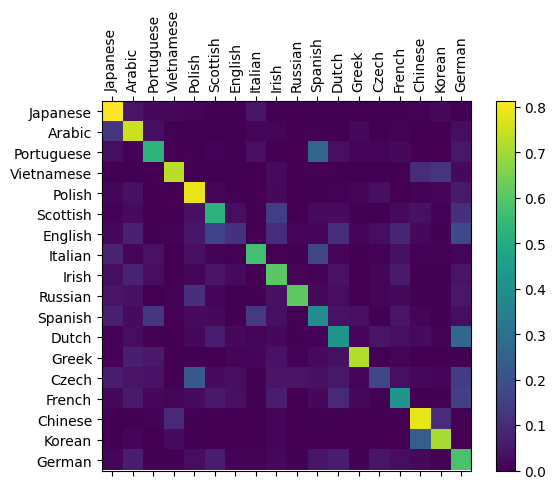

In [63]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [65]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(line_to_tensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.43) Russian
(-2.19) Czech
(-2.36) Polish

> Jackson
(-0.18) Scottish
(-2.31) English
(-3.73) Irish

> Satoshi
(-0.58) Japanese
(-1.94) Italian
(-2.13) Polish
